<a href="https://colab.research.google.com/github/KeqingW44448/api/blob/main/RSM8421/Tutorial_1_Code_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RSM8421: AI and Deep Learning Tools - Tutorial 1

Welcome to the first tutorial! In this notebook, we will build a handwritten digit classifier end-to-end using TensorFlow and Keras. The goal is to understand how each piece of code connects to the underlying machine learning concepts we have seen in the course.

By the end of this tutorial, you will know how to:
- inspect and visualize the MNIST dataset,
- construct a feed-forward neural network and reason about each layer, and
- monitor training metrics to judge whether the model is learning effectively.

Run each cell as you read the explanations. Try to anticipate what should happen before executing every block.

### Learning roadmap

1. Environment setup and reproducibility.
2. Data loading, normalization, and visual inspection.
3. Model building with `tf.keras.Sequential`.
4. Loss functions, optimization, and probability interpretation.
5. Training loops, diagnostics, and evaluation on unseen data.
6. Visualizing predictions and discussing next steps.

If you are new to Python notebooks, remember that cells run top-to-bottom; rerunning a cell updates any variables defined inside it.

## 1. Set up TensorFlow

Check https://www.tensorflow.org/install for guidelines on installing TensorFlow.

We begin by importing TensorFlow along with a couple of helper libraries for numerical computing and visualization. TensorFlow ships with the high-level Keras API that we will rely on to define layers quickly.

Run the cell below to verify your TensorFlow installation and see the version number.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
plt.rcParams['figure.figsize'] = (8, 5)
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


### Why set a random seed?

Neural networks make use of randomness when shuffling data and initializing weights. Setting the seed keeps results reproducible so that we see the same numbers every time we run this notebook.

In [2]:
tf.random.set_seed(42)
np.random.seed(42)
print('Seeds set for reproducibility.')

Seeds set for reproducibility.


## 2. Load and understand the dataset

The MNIST dataset contains 70,000 grayscale images of handwritten digits (0–9). Each image is 28 × 28 pixels. We will download the dataset, split it into training and test sets, and scale the pixel values to the 0–1 range to make optimization easier.

In [3]:
# Load and prepare the MNIST dataset
# MNIST is a classic dataset of 70,000 handwritten digits (0-9)
# Each image is 28x28 pixels, and each pixel is represented by a grayscale value
mnist = tf.keras.datasets.mnist

# The dataset is split into 60,000 training images and 10,000 test images
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train_raw = x_train.copy()
x_test_raw = x_test.copy()

# Every MNIST image is stored with unsigned 8‑bit pixel values in the range 0–255,
# dividing by 255.0 rescales those raw integers to the standard 0–1 range.
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print('Datasets downloaded and normalized.')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Datasets downloaded and normalized.


### Check the shapes and pixel ranges

Inspecting the data before modeling helps verify that loading and preprocessing behaved as expected.

In [4]:
print(f'x_train shape: {x_train.shape}, dtype: {x_train.dtype}')
print(f'x_test shape:  {x_test.shape}, dtype: {x_test.dtype}')

print(f'Number of training labels: {len(y_train)}')
print(f'Unique labels: {np.unique(y_train)}')

class_counts = np.bincount(y_train, minlength=10)
for digit, count in enumerate(class_counts):
    print(f'Digit {digit}: {count} examples')
print(f'Pixel range after scaling: {x_train.min():.1f} to {x_train.max():.1f}')

x_train shape: (60000, 28, 28), dtype: float32
x_test shape:  (10000, 28, 28), dtype: float32
Number of training labels: 60000
Unique labels: [0 1 2 3 4 5 6 7 8 9]
Digit 0: 5923 examples
Digit 1: 6742 examples
Digit 2: 5958 examples
Digit 3: 6131 examples
Digit 4: 5842 examples
Digit 5: 5421 examples
Digit 6: 5918 examples
Digit 7: 6265 examples
Digit 8: 5851 examples
Digit 9: 5949 examples
Pixel range after scaling: 0.0 to 1.0


### Visualize a few examples

Plotting sample images builds intuition for what the model sees. These are raw pixel values before scaling; lighter pixels indicate higher intensity.

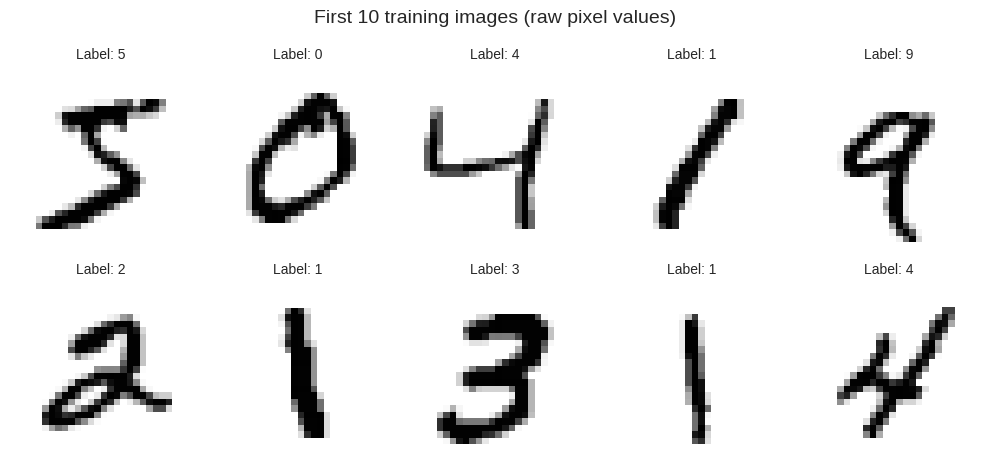

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for ax, image, label in zip(axes.flat, x_train_raw[:10], y_train[:10]):
    ax.imshow(image, cmap='binary')
    ax.set_title(f'Label: {label}', fontsize=10)
    ax.axis('off')
fig.suptitle('First 10 training images (raw pixel values)', fontsize=14)
plt.tight_layout()

## 3. Build a machine learning model

We will start with a simple fully connected neural network built with `tf.keras.Sequential`. The model first flattens each image into a vector, processes it through a dense (fully connected) layer with ReLU activation, applies dropout for regularization, and finishes with a layer that outputs logits for each of the 10 digit classes.

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])

The first `Input` layer defines the expected shape so we avoid warnings when constructing the model. Use `model.summary()` to confirm how tensors flow through the network.

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

[`Sequential`](https://www.tensorflow.org/guide/keras/sequential_model) is useful for stacking layers where each layer has one input [tensor](https://www.tensorflow.org/guide/tensor) and one output tensor. Layers are functions with a known mathematical structure that can be reused and have trainable variables. Most TensorFlow models are composed of layers. This model uses the [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten), [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), and [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers.

For each example, the model returns a vector of [logits](https://developers.google.com/machine-learning/glossary#logits) or [log-odds](https://developers.google.com/machine-learning/glossary#log-odds) scores, one for each class.

Notice in the summary above that the final dense layer has 10 outputs—one for each possible digit.

In [8]:
predictions = model(x_train[:1]).numpy()
predictions

array([[-0.2997222 , -0.05127844,  0.31035814, -0.30939198, -0.16291948,
        -0.46059138,  0.09079871, -0.41116637, -0.07369305, -0.414118  ]],
      dtype=float32)

These values are logits: unnormalized scores indicating how strongly the model leans toward each class before applying any probability function.

The `tf.nn.softmax` function converts these logits to *probabilities* for each class:

In [9]:
tf.nn.softmax(predictions).numpy()

array([[0.0859934 , 0.110246  , 0.15827768, 0.08516587, 0.0986002 ,
        0.07321508, 0.12707677, 0.07692466, 0.10780238, 0.07669794]],
      dtype=float32)

In [10]:
probabilities = tf.nn.softmax(predictions).numpy()
predicted_class = int(np.argmax(probabilities))
predicted_confidence = float(np.max(probabilities))
print(f'Predicted digit: {predicted_class}')
print(f'Confidence: {predicted_confidence:.2%}')
print(f'Ground-truth label: {y_train[0]}')

Predicted digit: 2
Confidence: 15.83%
Ground-truth label: 5


When the model is untrained the probabilities are close to uniform, so the confidence is low. After training we expect one class to stand out.

Note: It is possible to bake the `tf.nn.softmax` function into the activation function for the last layer of the network. While this can make the model output more directly interpretable, this approach is discouraged as it's impossible to provide an exact and numerically stable loss calculation for all models when using a softmax output.

Define a loss function for training using `losses.SparseCategoricalCrossentropy`:

In [11]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

The `from_logits=True` flag tells the loss function that the model outputs raw logits, so it will internally apply a numerically stable softmax before computing cross-entropy.

The loss function takes a vector of ground truth values and a vector of logits and returns a scalar loss for each example. This loss is equal to the negative log probability of the true class: The loss is zero if the model is sure of the correct class.

This untrained model gives probabilities close to random (1/10 for each class), so the initial loss should be close to `-tf.math.log(1/10) ~= 2.3`.

In [12]:
loss_fn(y_train[:1], predictions).numpy()

np.float32(2.6143537)

Before training we configure the optimization pipeline with `Model.compile`. We will use the Adam optimizer, the cross-entropy loss defined above, and track accuracy as our primary metric.

In [13]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

## 4. Train and evaluate your model

Use the `Model.fit` method to adjust your model parameters and minimize the loss:

In [14]:
history = model.fit(
    x_train,
    y_train,
    epochs=5,
    validation_split=0.1,
    verbose=2
)

Epoch 1/5
1688/1688 - 6s - 4ms/step - accuracy: 0.9102 - loss: 0.3101 - val_accuracy: 0.9668 - val_loss: 0.1218
Epoch 2/5
1688/1688 - 9s - 6ms/step - accuracy: 0.9544 - loss: 0.1520 - val_accuracy: 0.9733 - val_loss: 0.0918
Epoch 3/5
1688/1688 - 6s - 3ms/step - accuracy: 0.9664 - loss: 0.1117 - val_accuracy: 0.9782 - val_loss: 0.0779
Epoch 4/5
1688/1688 - 4s - 2ms/step - accuracy: 0.9717 - loss: 0.0930 - val_accuracy: 0.9785 - val_loss: 0.0731
Epoch 5/5
1688/1688 - 4s - 3ms/step - accuracy: 0.9760 - loss: 0.0770 - val_accuracy: 0.9800 - val_loss: 0.0676


Training returns a `History` object that stores metrics for each epoch. Plotting these curves makes it easier to explain how the model improves over time.

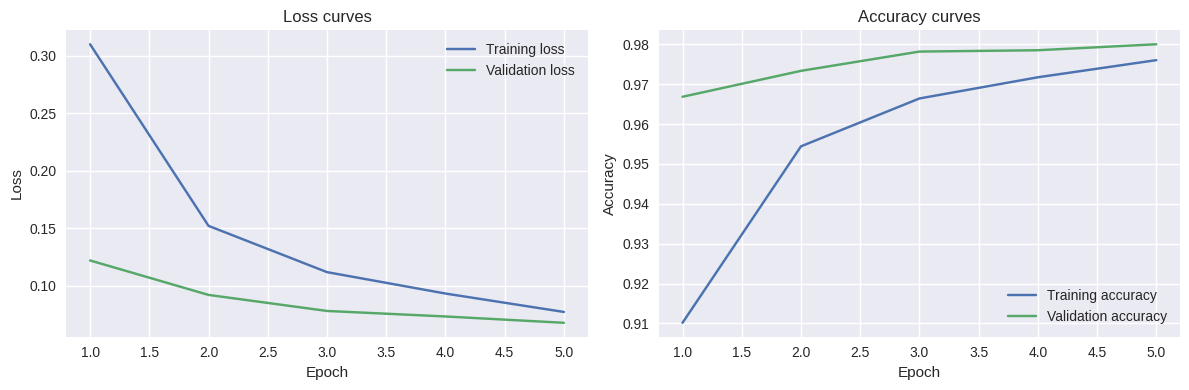

In [15]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(epochs, history_dict['loss'], label='Training loss')
axes[0].plot(epochs, history_dict['val_loss'], label='Validation loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss curves')
axes[0].legend()

axes[1].plot(epochs, history_dict['accuracy'], label='Training accuracy')
axes[1].plot(epochs, history_dict['val_accuracy'], label='Validation accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy curves')
axes[1].legend()

plt.tight_layout()

We look for training and validation curves that move in the same direction. Large gaps may indicate overfitting and provide a natural talking point about regularization.

The `Model.evaluate` method checks the model's performance on unseen data—in this case, the test set.

In [16]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy:.2%}')

Test loss: 0.0745
Test accuracy: 97.75%


Accuracy close to the training score tells us that the model generalizes well to digits it has not seen before.

The image classifier is now trained to about 98% accuracy on this dataset. To go further, you can experiment with deeper networks, convolutional layers, or data augmentation to handle more complex image tasks.

If you want your model to return a probability, you can wrap the trained model, and attach the softmax to it:

In [17]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [18]:
probability_model(x_test[:5])

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[1.53407896e-07, 2.29149366e-09, 3.35127834e-06, 1.57628136e-04,
        7.98625272e-13, 1.44027652e-07, 2.44959950e-13, 9.99832153e-01,
        1.37341408e-06, 5.14111389e-06],
       [4.50362525e-11, 4.43103527e-05, 9.99952078e-01, 3.49426159e-06,
        1.92085020e-17, 2.46989167e-08, 3.26041705e-09, 1.46100200e-13,
        1.10294970e-07, 1.00372456e-14],
       [1.08235861e-06, 9.98854518e-01, 7.20828320e-05, 2.91374581e-05,
        1.69782405e-04, 5.49556989e-06, 8.70311997e-05, 5.88131603e-04,
        1.92102860e-04, 7.16776924e-07],
       [9.99868155e-01, 1.05918211e-07, 4.29847241e-05, 5.79133598e-07,
        1.38996210e-08, 1.02960018e-06, 8.38087071e-05, 3.10665155e-06,
        2.84707524e-09, 2.36650891e-07],
       [2.79470933e-05, 3.73556130e-10, 6.47287879e-06, 7.20066922e-08,
        9.98347402e-01, 3.15805920e-07, 1.42811950e-05, 4.26636761e-05,
        3.48803860e-06, 1.55736331e-03]], dtype=float32)>

To make the predictions easier to interpret, let's visualize a few test images alongside the model's predicted labels and confidence scores.

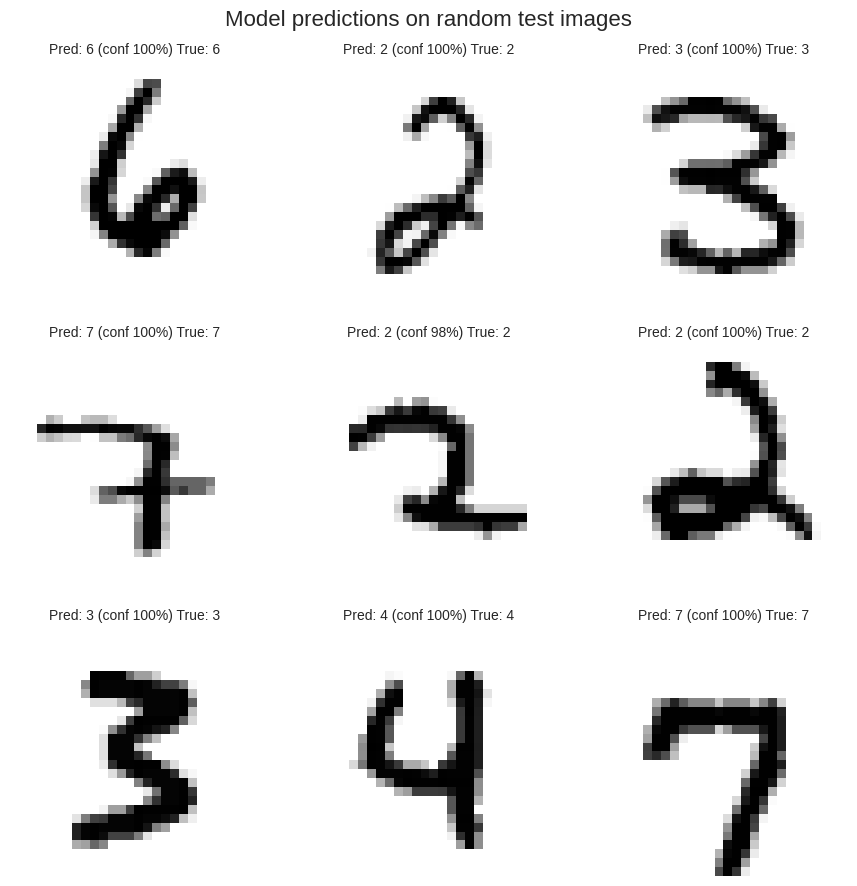

In [19]:
sample_indices = np.random.choice(len(x_test), size=9, replace=False)
sample_images = x_test[sample_indices]
sample_labels = y_test[sample_indices]

sample_probabilities = probability_model(sample_images).numpy()
sample_predictions = np.argmax(sample_probabilities, axis=1)

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for ax, image, pred, truth, probs in zip(axes.flat, sample_images, sample_predictions, sample_labels, sample_probabilities):
    confidence = np.max(probs)
    ax.imshow(image, cmap='binary')
    ax.set_title(f'Pred: {pred} (conf {confidence:.0%}) True: {truth}', fontsize=10)
    ax.axis('off')

fig.suptitle('Model predictions on random test images', fontsize=16)
plt.tight_layout()

Congratulations! You have walked through the entire modeling workflow: exploring the data, designing a network, training with diagnostics, evaluating on held-out data, and visualizing predictions.

For more examples of using Keras, check out the [tutorials](https://www.tensorflow.org/tutorials/keras/).